The data is available as two attached CSV files:
takehome_user_engagement. csv
takehome_users . csv

The data has the following two tables:

1] A user table ( "takehome_users" ) with data on 12,000 users who signed up for the
product in the last two years. This table includes:

● name: the user's name

● object_id: the user's id

● email: email address

● creation_source: how their account was created. This takes on one
of 5 values:

○ PERSONAL_PROJECTS: invited to join another user's
personal workspace

○ GUEST_INVITE: invited to an organization as a guest
(limited permissions)

○ ORG_INVITE: invited to an organization (as a full member)

○ SIGNUP: signed up via the website

○ SIGNUP_GOOGLE_AUTH: signed up using Google

Authentication (using a Google email account for their login
id)

● creation_time: when they created their account

● last_session_creation_time: unix timestamp of last login

● opted_in_to_mailing_list: whether they have opted into receiving
marketing emails

● enabled_for_marketing_drip: whether they are on the regular
marketing email drip

● org_id: the organization (group of users) they belong to

● invited_by_user_id: which user invited them to join (if applicable).


2] A usage summary table ( "takehome_user_engagement" ) that has a row for each day
that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday period , identify which factors predict future user
adoption .

We suggest spending 1-2 hours on this, but you're welcome to spend more or less.
Please send us a brief writeup of your findings (the more concise, the better no more
than one page), along with any summary tables, graphs, code, or queries that can help
us understand your approach. Please note any factors you considered or investigation
you did, even if they did not pan out. Feel free to identify any further research or data
you think would be valuable.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [85]:
df_users = pd.read_csv('takehome_users.csv',encoding = "ISO-8859-1")

In [86]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [87]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [88]:
df_user_engagement = pd.read_csv('takehome_user_engagement.csv',encoding = "ISO-8859-1")

In [89]:
df_user_engagement.head() 

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [90]:
df_user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [91]:
df_user_engagement['date'] = pd.to_datetime(df_user_engagement['time_stamp']).dt.date

In [92]:
def logins_in_days(df, days=7, logins=3):
    from datetime import timedelta
    
    # first drop duplicate days and sort by day
    df = df.drop_duplicates(subset='date').sort_values('date')
    
    # calculate how many days has passed for every 3 logins
    passed_days = df['date'].diff(periods = logins-1)
        
    # check if any passed time is less than 7 days
    return any(passed_days <= timedelta(days=days))

In [93]:
# run the function on all users

adopted = df_user_engagement.groupby('user_id').apply(logins_in_days).replace({True:1,False:0})
adopted.name = 'adopted_user'

In [94]:
print('There were {} adopted users out of {} users'.format(sum(adopted), len(adopted)))

There were 1656 adopted users out of 8823 users


In [95]:
#Concat adopted user with Users data and create new data

In [96]:
df_users = df_users.set_index('object_id')
df_users.index.name = 'user_id'

data = pd.concat([df_users, adopted], axis=1, join='inner')
data['adopted_user'] = data['adopted_user'].astype(int)

In [97]:
data.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
user_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [98]:
#month of creation
data['creation_month'] = pd.to_datetime(data['creation_time']).dt.month

In [99]:
#month of year
data['creation_year'] = pd.to_datetime(data['creation_time']).dt.year

In [100]:
data.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,creation_month,creation_year
user_id,,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,4,2014
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,11,2013
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,3,2013
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,5,2013
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,1,2013


In [105]:
#encodings
from sklearn import preprocessing

class Categorical_encoding:
    def __init__(self, df, categorical_features):
        self.df = df
        self.output_df = self.df.copy(deep=True)
        self.cat_features = categorical_features
        
        for c in self.cat_features:
            self.df.loc[:,c] = self.df.loc[:,c].astype(str).fillna(-1)
    
    def label_encoding(self):
        for c in self.cat_features:
            lbl = preprocessing.LabelEncoder()
            lbl.fit(self.df[c].values)
            self.output_df.loc[:,c] = lbl.transform(self.df[c].values)
        
        return self.output_df

In [106]:
cols = ['creation_source']        
o_df = Categorical_encoding(data,cols)  
data = o_df.label_encoding()

In [107]:
data.columns

Index(['creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adopted_user', 'creation_month', 'creation_year'],
      dtype='object')

In [ ]:
#To see and an idea of variavles are related to each other we plot a pairplot.

/Users/Anand/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/Anand/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/Anand/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/Anand/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


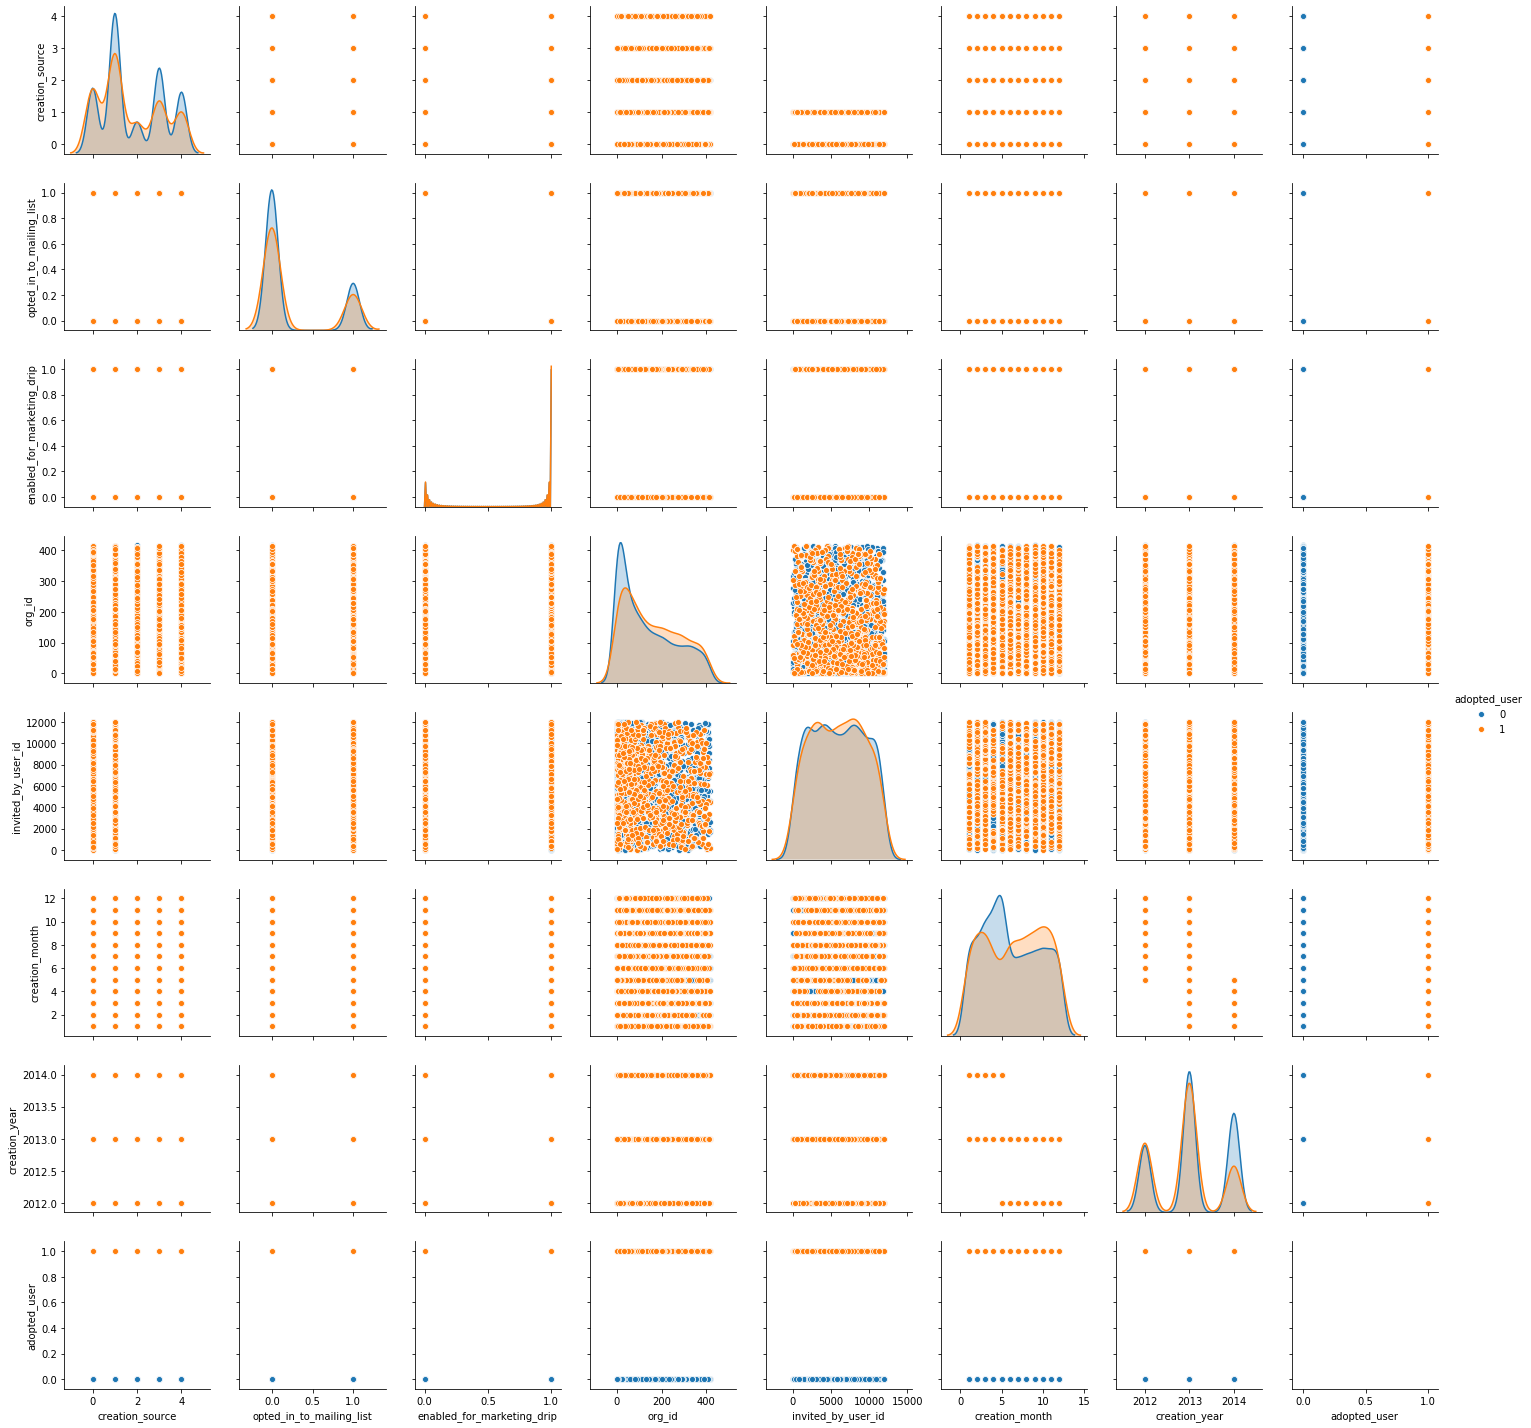

In [112]:
featureList = [ 'creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id','invited_by_user_id'
                 ,'creation_month', 'creation_year','adopted_user']
    
import seaborn as sns
sns.pairplot(data[featureList],hue='adopted_user')

**From the above pairplot, we don't have much valuable information**

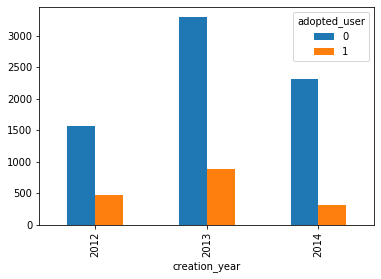

In [103]:
data.groupby(['creation_year','adopted_user'])['adopted_user'].count().unstack().plot(kind='bar')

**In year 2013 max accounts are created**

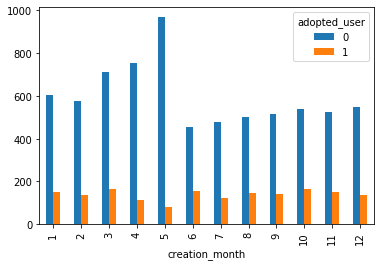

In [104]:
data.groupby(['creation_month','adopted_user'])['adopted_user'].count().unstack().plot(kind='bar')

**Overall first half of year has more accounts created, and there is a sudden drop from 6th month.** 

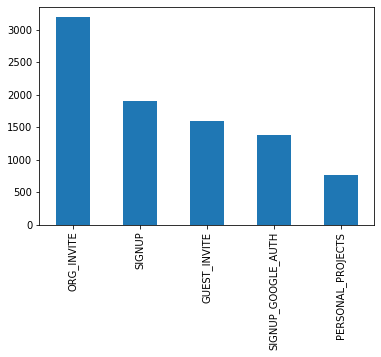

In [41]:
data['creation_source'].value_counts().plot(kind='bar')

**Most of the accounts were created as ORG_INVITE i.e via invitation of organisation.**

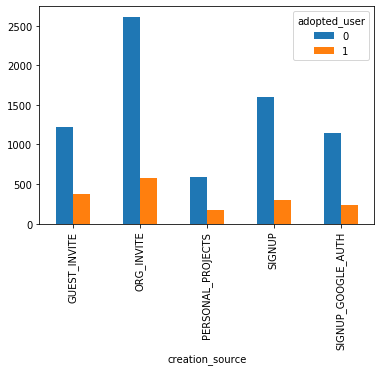

In [44]:
data.groupby(['creation_source','adopted_user'])['adopted_user'].count().unstack().plot(kind='bar')

**ORG_INVITE has relatively higher proportion of non adoption users.**

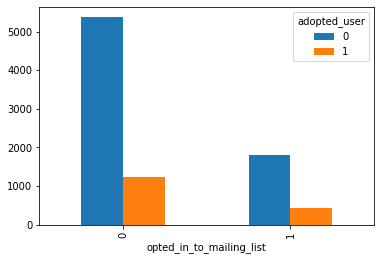

In [45]:
data.groupby(['opted_in_to_mailing_list','adopted_user'])['adopted_user'].count().unstack().plot(kind='bar')

**There is relatively higher possibility for user to be adoption user if he opts for mailing list.**

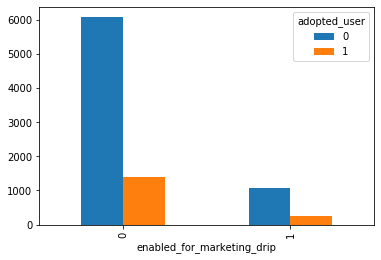

In [46]:
data.groupby(['enabled_for_marketing_drip','adopted_user'])['adopted_user'].count().unstack().plot(kind='bar')

**There is relatively higher possibility for user to be adoption user if he eanbled for marketing drip.**

In [ ]:
#org_id

In [73]:
data['org_id'].value_counts() 

0      228
1      172
2      150
3      125
4      122
      ... 
322      6
400      6
397      5
386      4
416      2
Name: org_id, Length: 417, dtype: int64

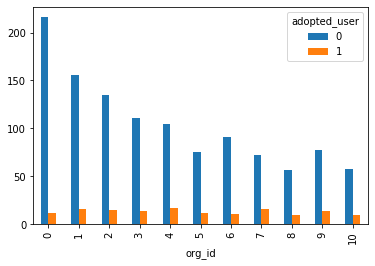

In [74]:
#Consider top 10 frequent org_id
data[data['org_id']<=10].groupby(['org_id','adopted_user'])['adopted_user'].count().unstack().plot(kind='bar')

**Org_id = 0 has relatively less proportion of adoption users.**

In [80]:
#insight on users inviting 

In [81]:
users_inviting = data['invited_by_user_id'].value_counts() 

In [83]:
print('Out of {} users, {} users invite'.format(len(df_users.index),len(users_inviting)))

Out of 12000 users, 2229 users invite


**Out of 12000 users, 2229 users invite**

**Approach to find features to predict adoption users:**
  
  1.From the above plot based on domain expertise or intuition we can say that the following variables are of importance for predicting the adoption users as there is a lot of variance with respect to dependent variable.
  
    creation_year
    creation_month
    creation_source
    opted_in_to_mailing_list
    enabled_for_marketing_drip
    org_id
  
  2.Hypothesis test can be performed, to get more concrete answers to assumptions or results derived from the plots.

  2.Further Sklearn feature selection can used to reduce these features based on statistical test.  